In [15]:
import os
import numpy as np
import cv2
import torch

from drot.tune import KLTripletOptimizer
from drot.ot import *
from drot.plot import *

In [3]:
RAW_DISP = "disp.bin"
POST_DISP = "disp_postprocess.bin"
SAM_V2_VITL = "dam_v2_vitl_out.npy"
SAM_V2_VITB = "dam_v2_vitb_out.npy"
SAM_V2_VITS = "dam_v2_vits_out.npy"
LEFT_GRAY = "left.bmp"

In [4]:
def load_bin(path, h, w):
    return np.fromfile(path, dtype=np.uint16, count=h*w).reshape((h, w))

In [5]:
class Experiment:
    def __init__(self, base_dir, n_epochs, w_kl, w_hu):
        self.n_epoches = n_epochs
        self.w_kl = w_kl
        self.w_hu = w_hu

        folder = base_dir.split("/")[-1]
        print(f"processing {folder} now ...")
        left_gray_path = os.path.join(base_dir, LEFT_GRAY)
        left_gray = cv2.imread(left_gray_path, cv2.IMREAD_GRAYSCALE)
        print("The original input image is: ")
        cm_left = apply_colormap(left_gray)
        figure_show(cm_left)
        h, w = left_gray.shape
        raw_disp = load_bin(os.path.join(base_dir, RAW_DISP), h, w) / 64
        post_disp = load_bin(os.path.join(base_dir, POST_DISP), h, w) / 64
        vitl_disp = np.load(os.path.join(base_dir, SAM_V2_VITL))
        vitb_disp = np.load(os.path.join(base_dir, SAM_V2_VITB))
        vits_disp = np.load(os.path.join(base_dir, SAM_V2_VITS))

        self.agg_map = {
            "raw":raw_disp,
            "post":post_disp,
        }

        self.dl_map = {
            "s":vits_disp,
            "b":vitb_disp,
            "l":vitl_disp,
        }

    def pipeline(self):
        for d in self.agg_map.keys():
            print(f"Showing {d} disp colormap ...")
            figure_show(self.agg_map[d])
            for v in self.dl_map.keys():
                print(f"We are processing {d} disp for target and vit_{v} for reference...")
                print(f"Showing vit_{v} reference colormap ...")
                figure_show(self.dl_map[v])
                
                insufficient_indices = np.where(self.agg_map[d] == 0)
                dl = np.copy(self.dl_map[v])
                dl[insufficient_indices] = 0

                norm_d, minv_d, maxv_d = minmax_normalizer(self.agg_map[d])   # for agg
                norm_v, minv_v, maxv_v = minmax_normalizer(dl)    # for dl
                optimal_t = ot_transport_emd(norm_d, norm_v)
                optimal_t_r = restore_from_minmax(optimal_t, minv_d, maxv_d)

                xs = torch.tensor(optimal_t_r, dtype=torch.float32).unsqueeze(0).clone().detach().requires_grad_(True)
                xt = torch.tensor(self.agg_map[d], dtype=torch.float32).unsqueeze(0)
                xd = torch.tensor(dl, dtype=torch.float32).unsqueeze(0)

                kl_optim = KLTripletOptimizer(xs, xt, xd)
                kl_optim.weights_adjust(self.w_kl, self.w_hu)
                kl_optim.train(self.n_epoches)

                self._plotter(kl_optim)

                o_t = kl_optim.xs.cpu().squeeze(0).detach().numpy()
                o_t[o_t < 1] = 0
                print(f"Final refined optimal disp colormap ...")
                figure_show(o_t)

                print(f"The mean disparity level difference is {np.mean(o_t - self.agg_map[d])}")
                print(f"Showing difference colormap ...")
                figure_show(o_t - self.agg_map[d], 0, 0, 1)

    def _plotter(self, optimizer:KLTripletOptimizer):
        plt.figure(figsize=(10, 5))
        plt.plot(optimizer.total_losses, label='Total Loss')
        plt.plot(optimizer.kl_losses, label='KL Divergence Loss')
        plt.plot(optimizer.huber_losses, label='Huber Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss Progression During Training')
        plt.legend()
        plt.grid(True)
        plt.show()
    

In [16]:
top_dir = "D:/william/data/disp-refine/feynman2"
n_epoches = 1500
w_kl = 200000
w_hu = 1
folders = [f for f in os.listdir(top_dir) if os.path.isdir(os.path.join(top_dir, f))]
folders

['1', '2', '3']

processing feynman2\1 now ...
The original input image is: 


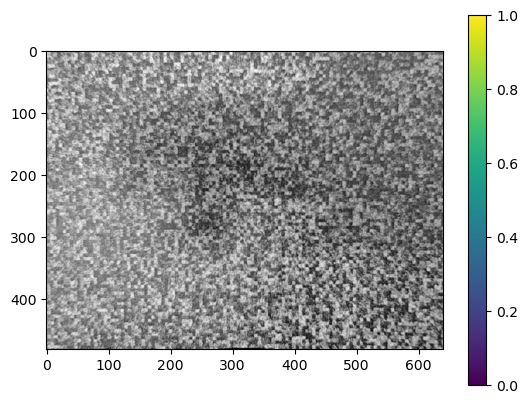

Showing raw disp colormap ...


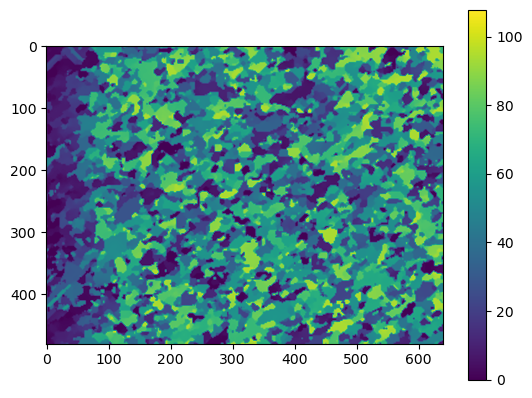

We are processing raw disp for target and vit_s for reference...
Showing vit_s reference colormap ...


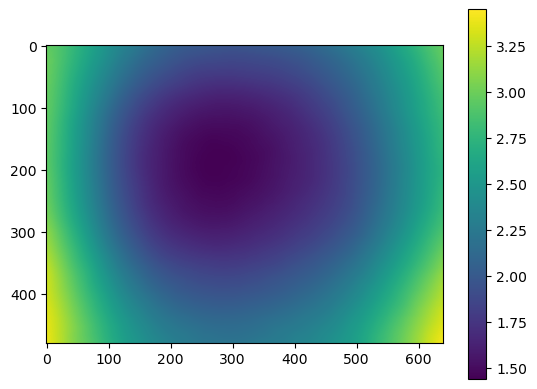

Running on: cuda


100%|██████████| 1500/1500 [00:07<00:00, 191.14it/s]


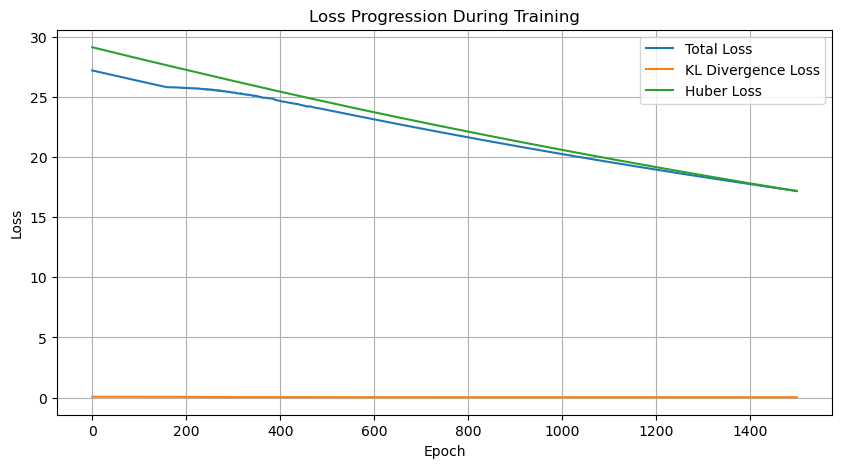

Final refined optimal disp colormap ...


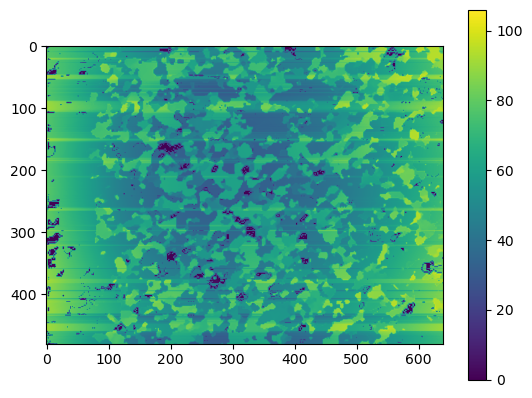

The mean disparity level difference is 14.65910157422962
Showing difference colormap ...


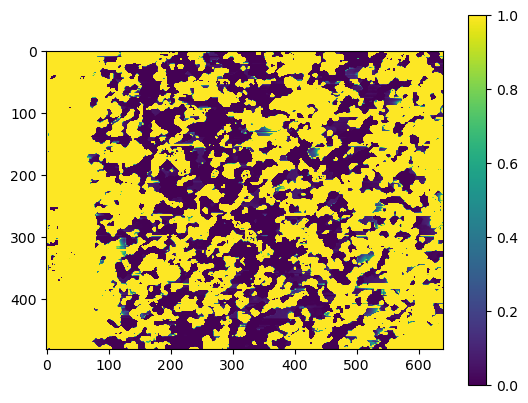

We are processing raw disp for target and vit_b for reference...
Showing vit_b reference colormap ...


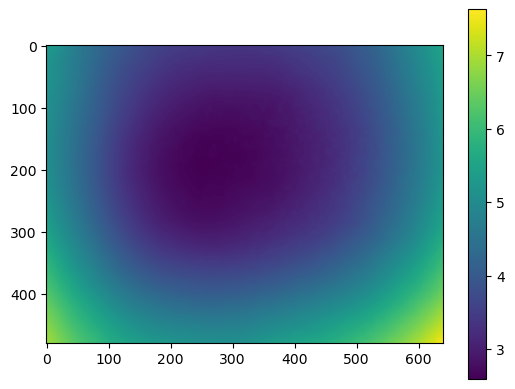

Running on: cuda


100%|██████████| 1500/1500 [00:07<00:00, 192.70it/s]


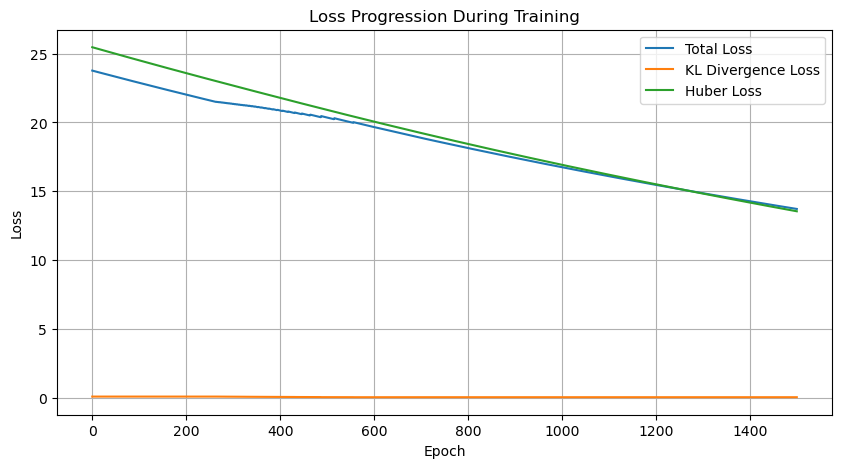

Final refined optimal disp colormap ...


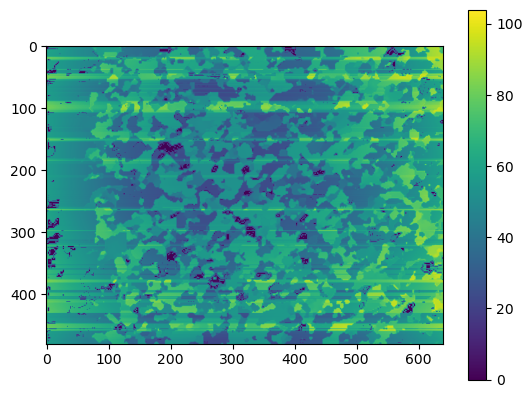

The mean disparity level difference is 7.815398719124496
Showing difference colormap ...


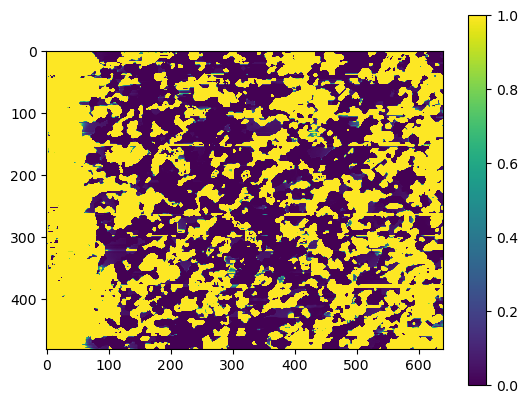

We are processing raw disp for target and vit_l for reference...
Showing vit_l reference colormap ...


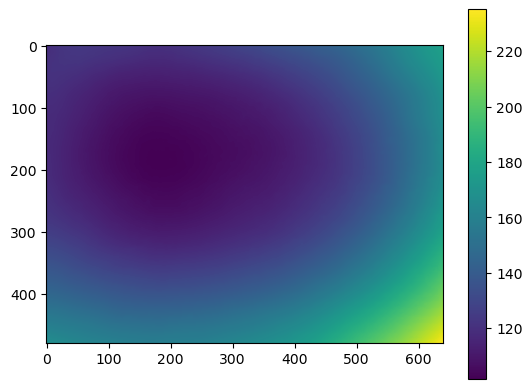

Running on: cuda


100%|██████████| 1500/1500 [00:10<00:00, 144.35it/s]


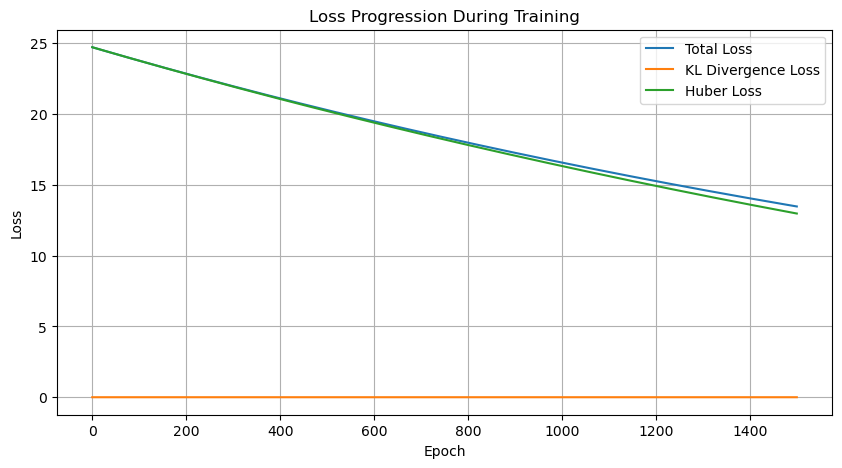

Final refined optimal disp colormap ...


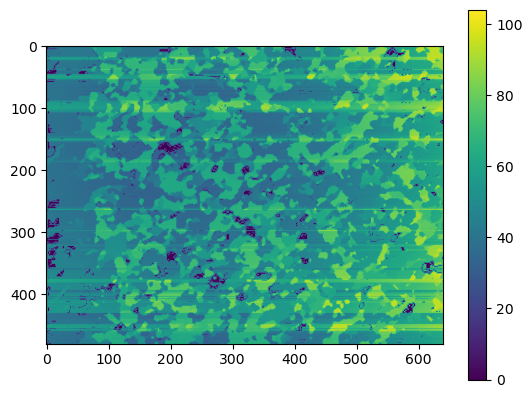

The mean disparity level difference is 9.823862067466834
Showing difference colormap ...


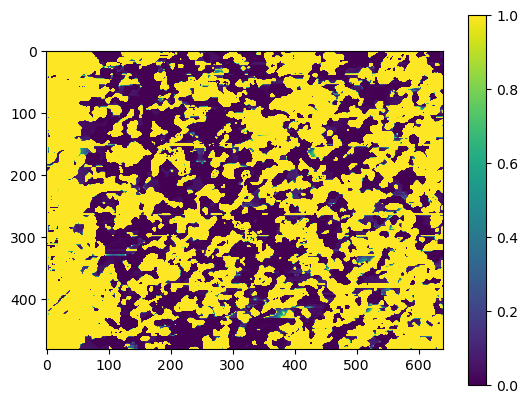

Showing post disp colormap ...


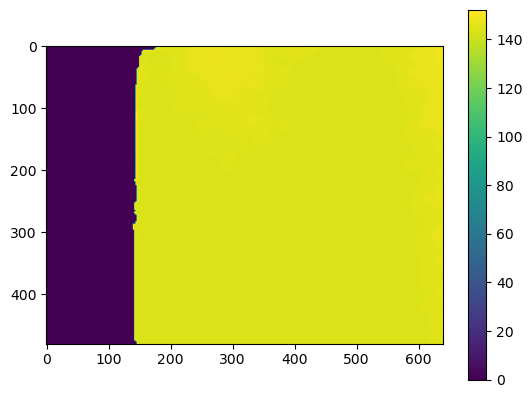

We are processing post disp for target and vit_s for reference...
Showing vit_s reference colormap ...


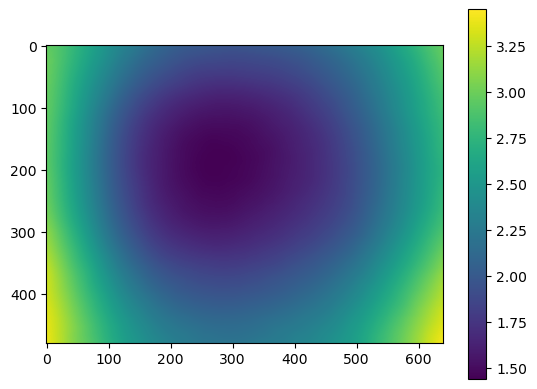

Running on: cuda


100%|██████████| 1500/1500 [00:06<00:00, 218.71it/s]


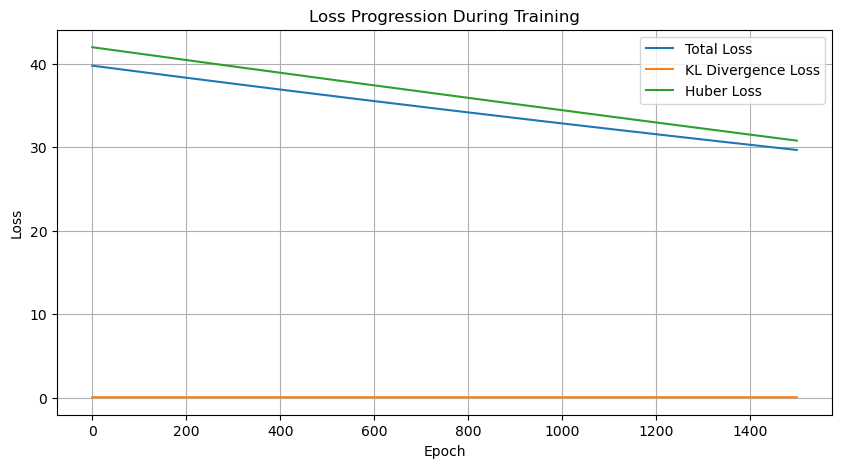

Final refined optimal disp colormap ...


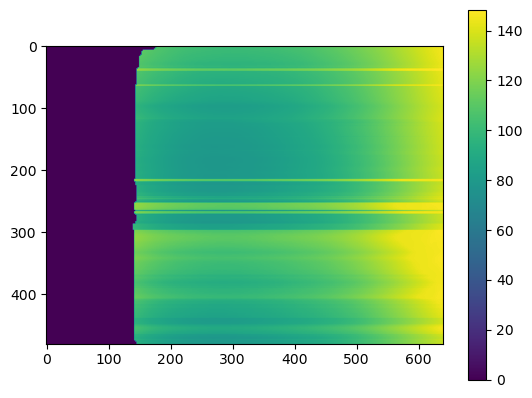

The mean disparity level difference is -31.147951855510474
Showing difference colormap ...


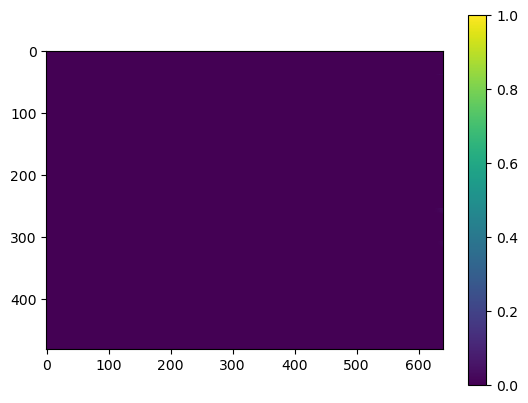

We are processing post disp for target and vit_b for reference...
Showing vit_b reference colormap ...


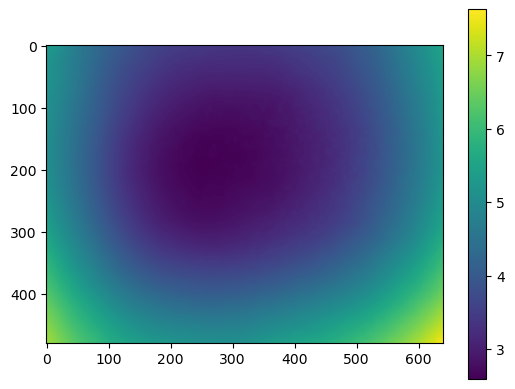

Running on: cuda


100%|██████████| 1500/1500 [00:06<00:00, 215.02it/s]


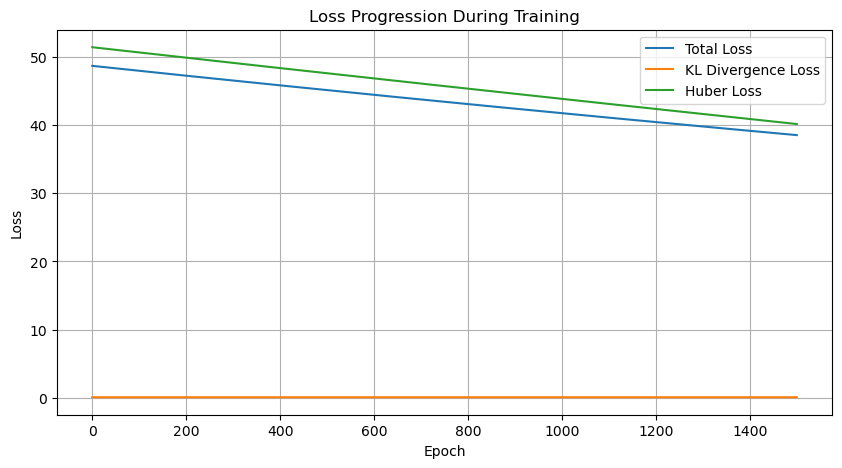

Final refined optimal disp colormap ...


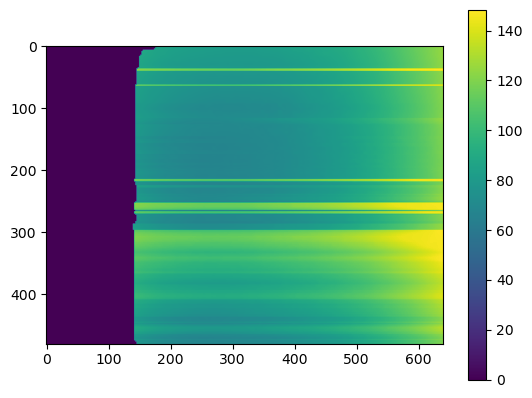

The mean disparity level difference is -40.549427152698236
Showing difference colormap ...


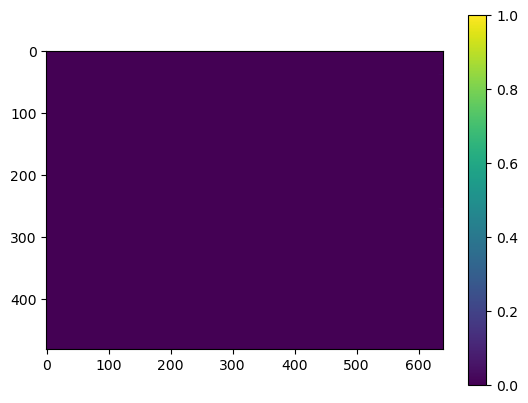

We are processing post disp for target and vit_l for reference...
Showing vit_l reference colormap ...


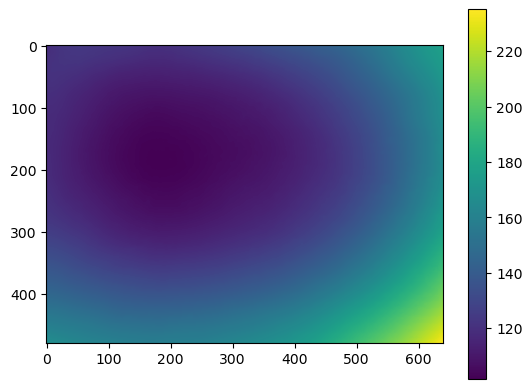

Running on: cuda


100%|██████████| 1500/1500 [00:08<00:00, 172.25it/s]


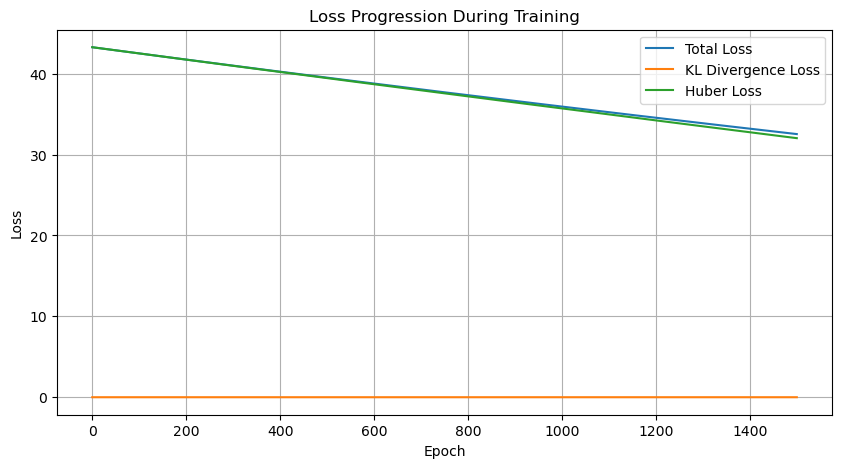

Final refined optimal disp colormap ...


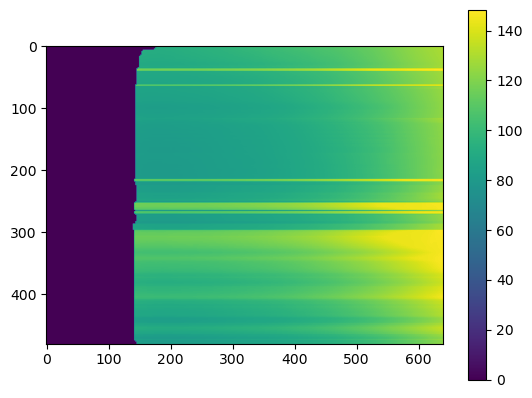

The mean disparity level difference is -32.40436205493907
Showing difference colormap ...


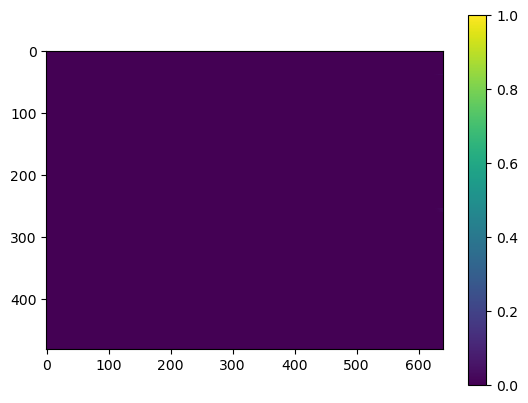

processing feynman2\2 now ...
The original input image is: 


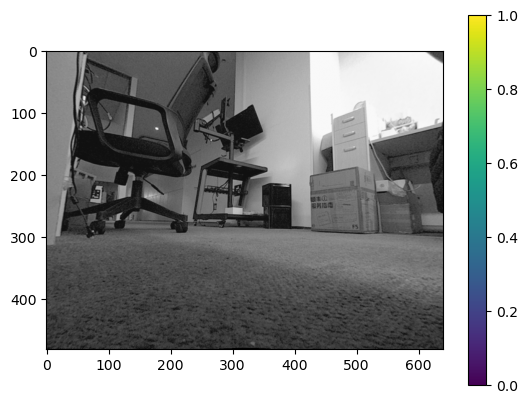

Showing raw disp colormap ...


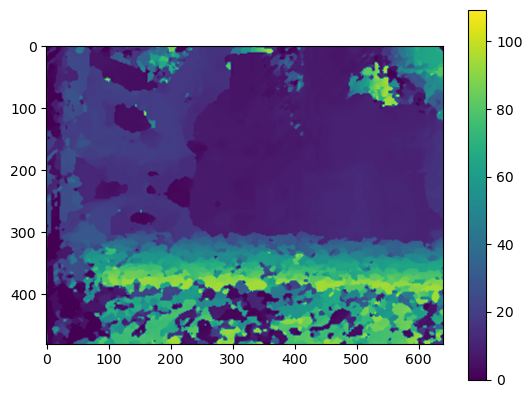

We are processing raw disp for target and vit_s for reference...
Showing vit_s reference colormap ...


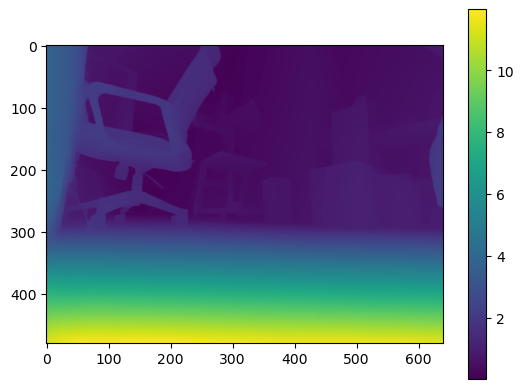

Running on: cuda


100%|██████████| 1500/1500 [00:07<00:00, 197.77it/s]


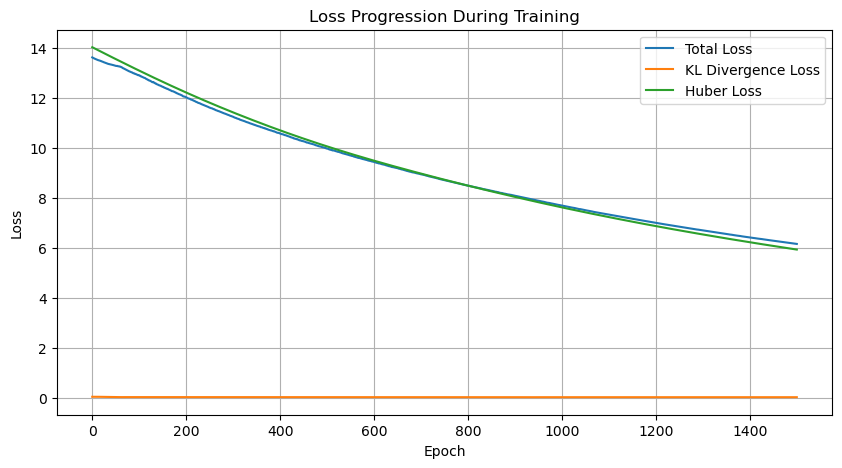

Final refined optimal disp colormap ...


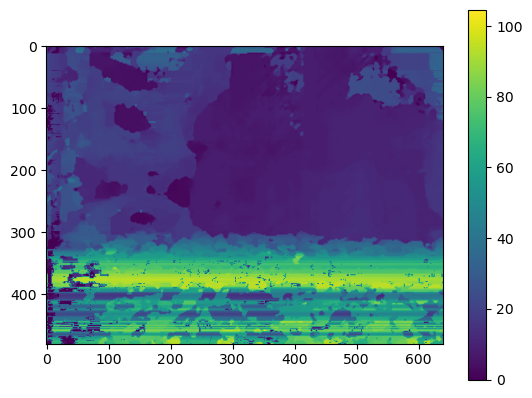

The mean disparity level difference is 1.9290098862260736
Showing difference colormap ...


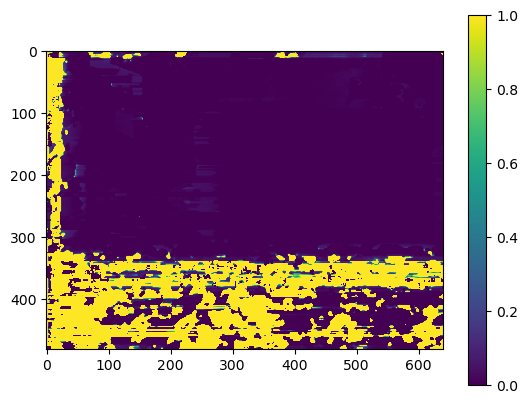

We are processing raw disp for target and vit_b for reference...
Showing vit_b reference colormap ...


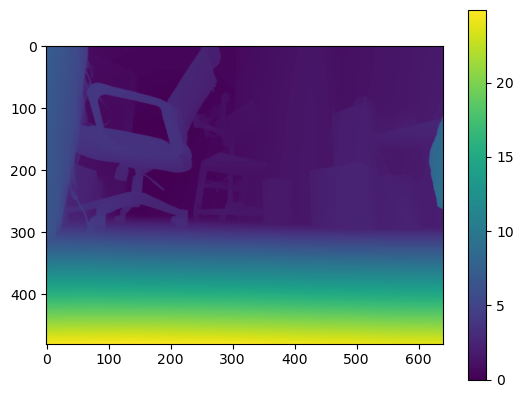

Running on: cuda


100%|██████████| 1500/1500 [00:07<00:00, 188.81it/s]


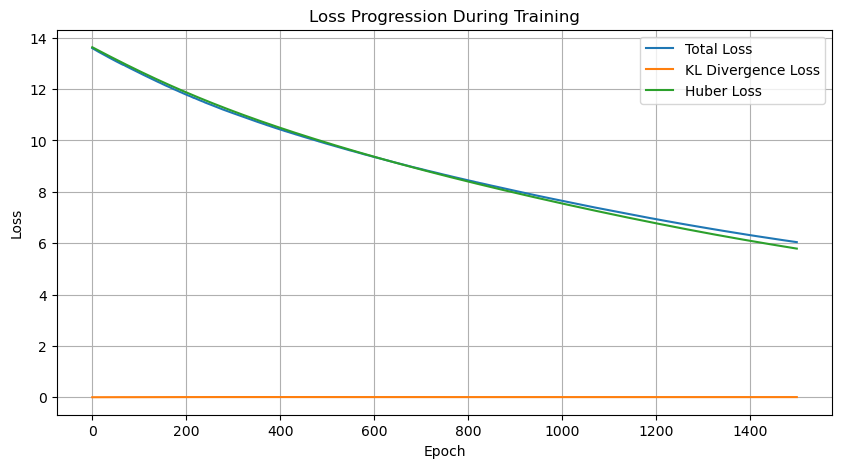

Final refined optimal disp colormap ...


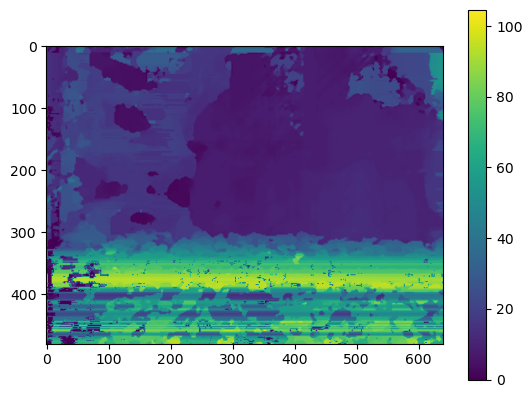

The mean disparity level difference is 1.9213373239412128
Showing difference colormap ...


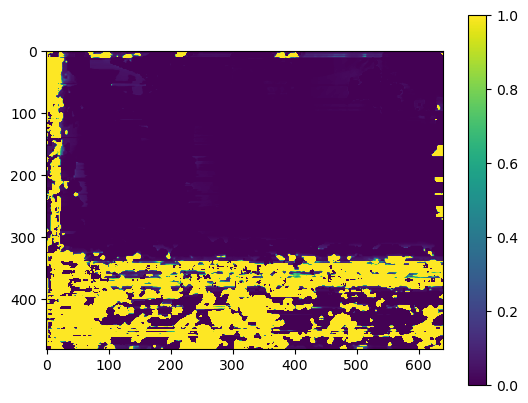

We are processing raw disp for target and vit_l for reference...
Showing vit_l reference colormap ...


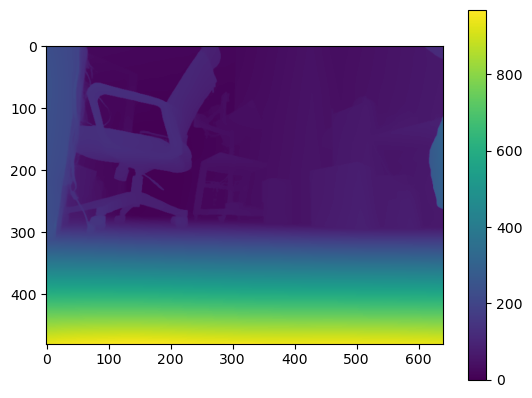

Running on: cuda


100%|██████████| 1500/1500 [00:09<00:00, 152.13it/s]


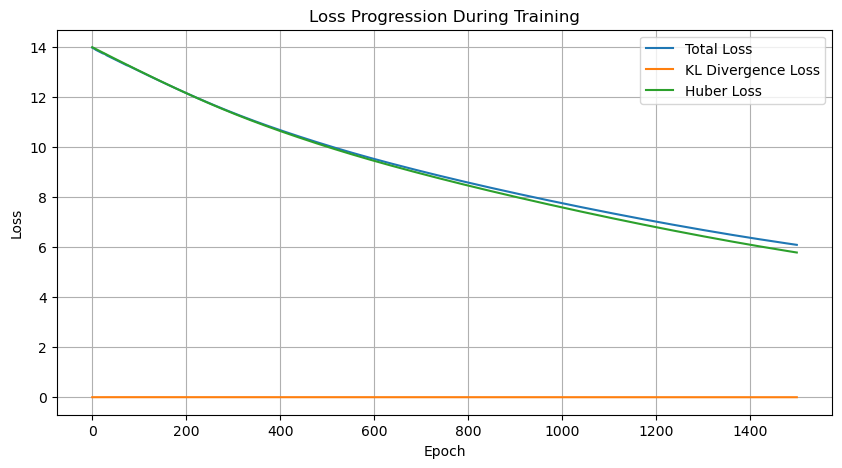

Final refined optimal disp colormap ...


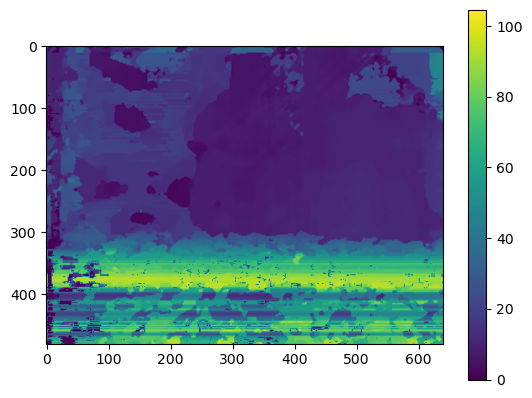

The mean disparity level difference is 1.6305397563159931
Showing difference colormap ...


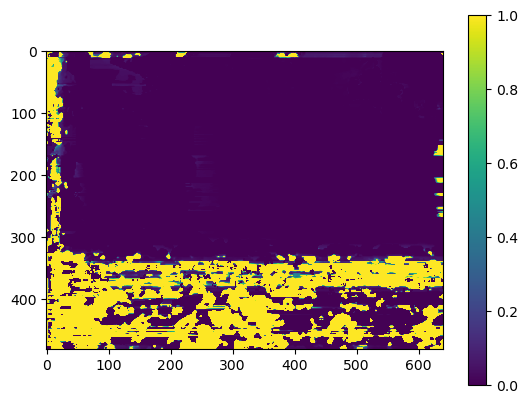

Showing post disp colormap ...


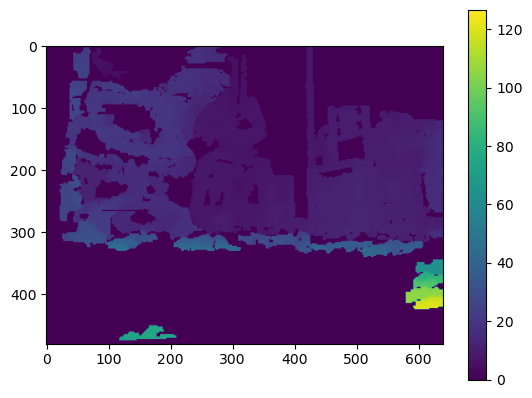

We are processing post disp for target and vit_s for reference...
Showing vit_s reference colormap ...


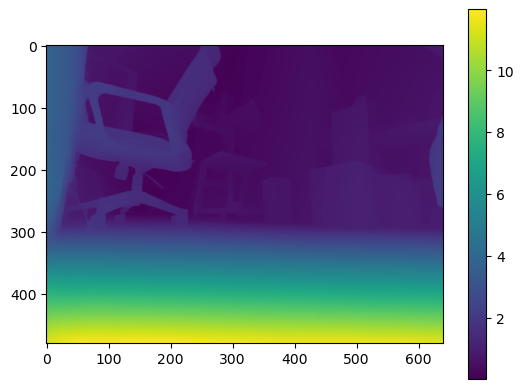

Running on: cuda


100%|██████████| 1500/1500 [00:07<00:00, 208.92it/s]


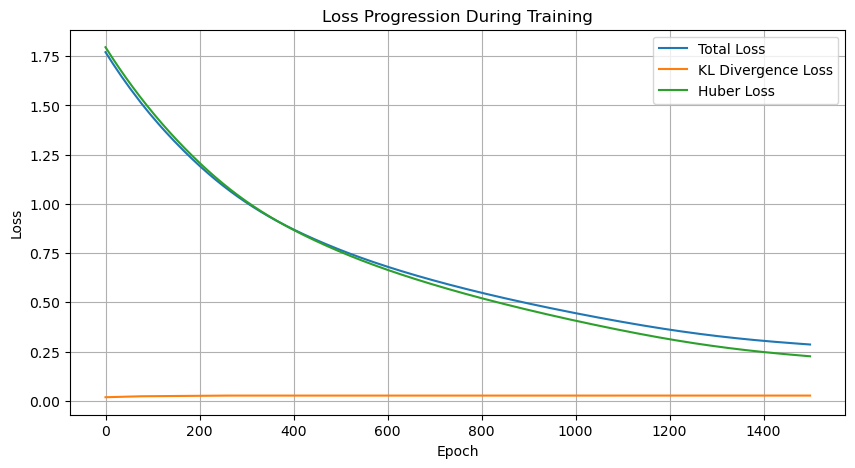

Final refined optimal disp colormap ...


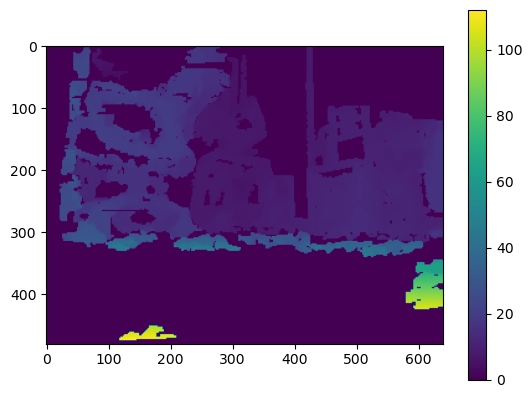

The mean disparity level difference is -0.0244418249768205
Showing difference colormap ...


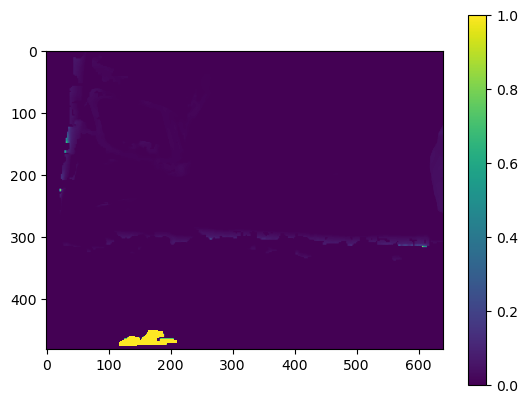

We are processing post disp for target and vit_b for reference...
Showing vit_b reference colormap ...


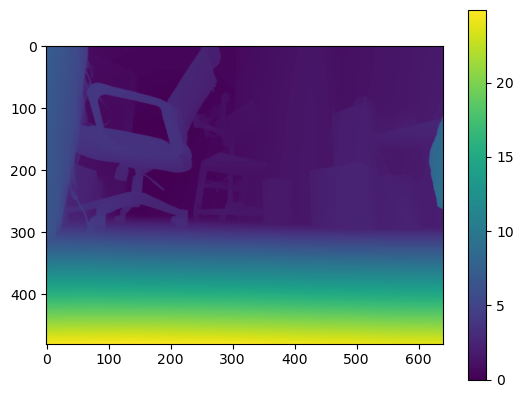

Running on: cuda


100%|██████████| 1500/1500 [00:07<00:00, 205.41it/s]


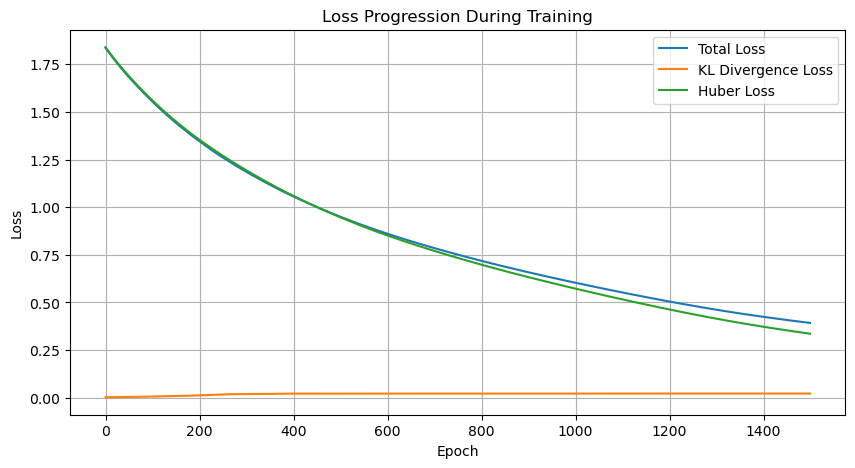

Final refined optimal disp colormap ...


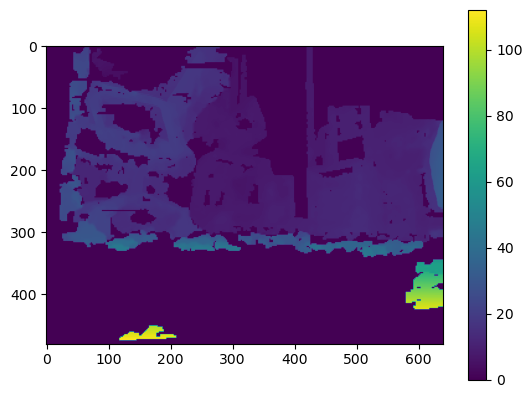

The mean disparity level difference is 0.0459792073094286
Showing difference colormap ...


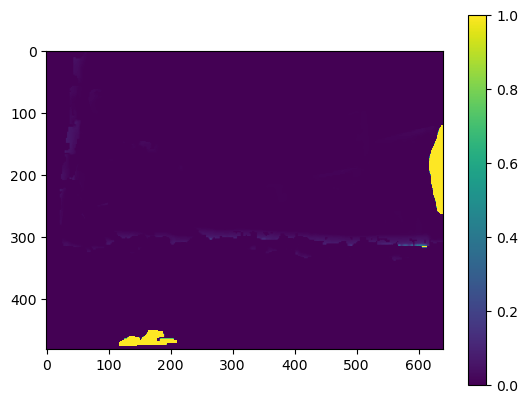

We are processing post disp for target and vit_l for reference...
Showing vit_l reference colormap ...


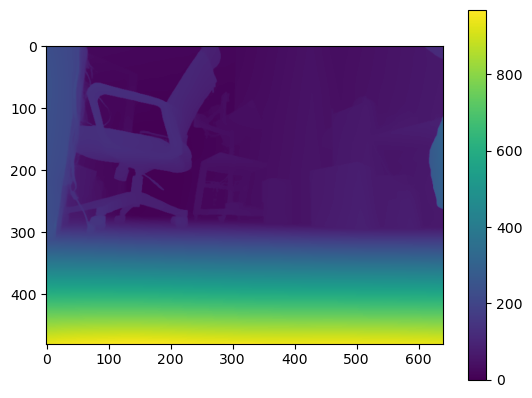

Running on: cuda


100%|██████████| 1500/1500 [00:07<00:00, 201.46it/s]


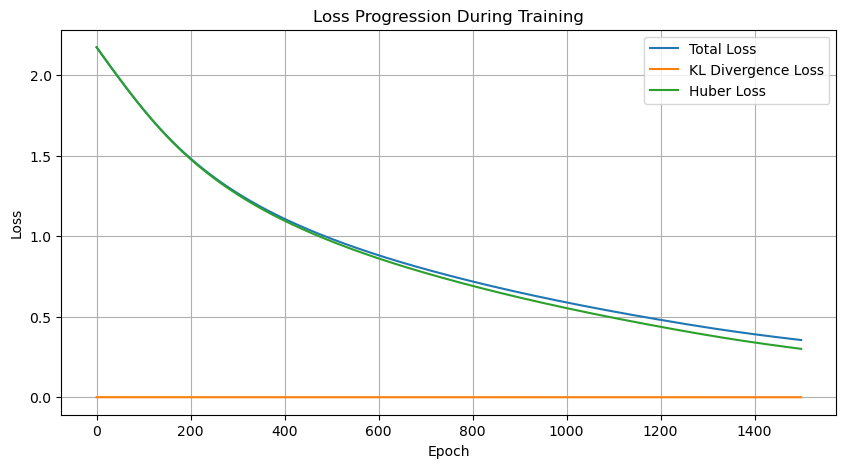

Final refined optimal disp colormap ...


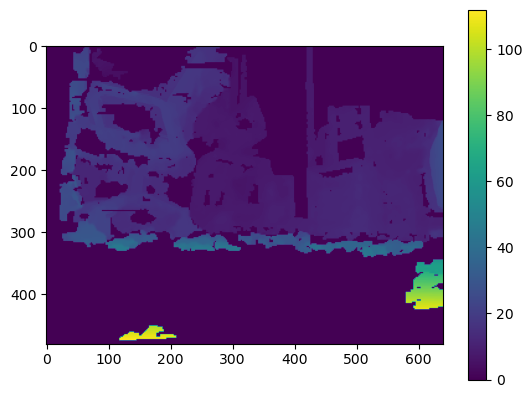

The mean disparity level difference is -0.002858007853695502
Showing difference colormap ...


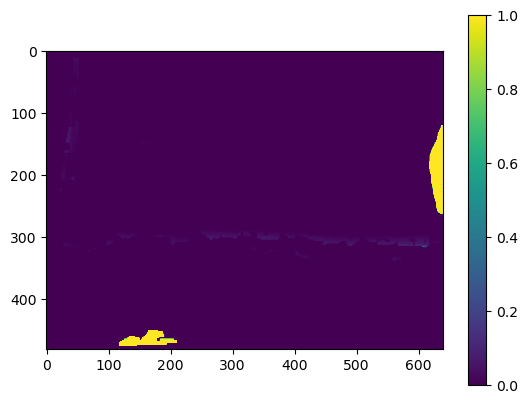

processing feynman2\3 now ...
The original input image is: 


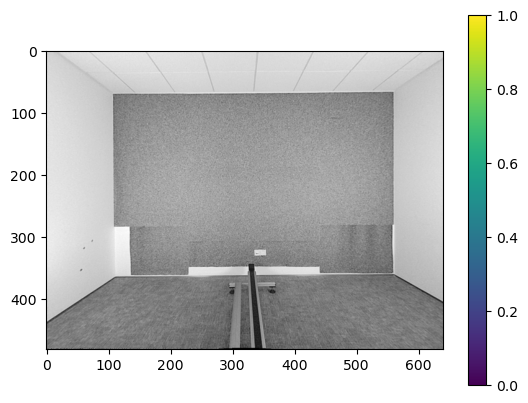

Showing raw disp colormap ...


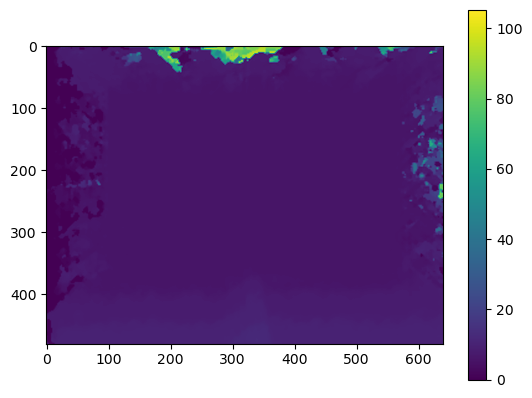

We are processing raw disp for target and vit_s for reference...
Showing vit_s reference colormap ...


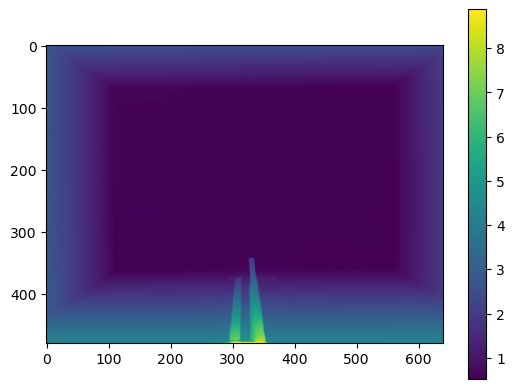

Running on: cuda


100%|██████████| 1500/1500 [00:06<00:00, 228.34it/s]


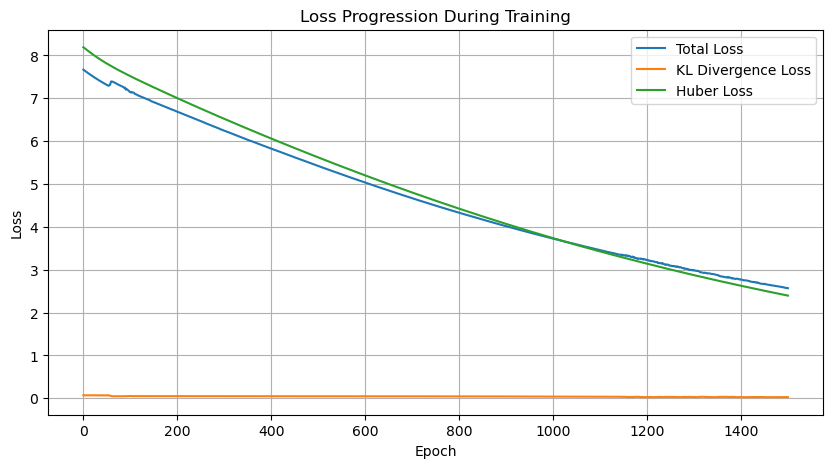

Final refined optimal disp colormap ...


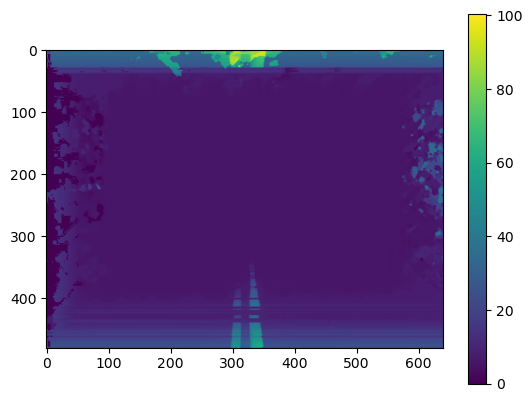

The mean disparity level difference is 2.2586368267703802
Showing difference colormap ...


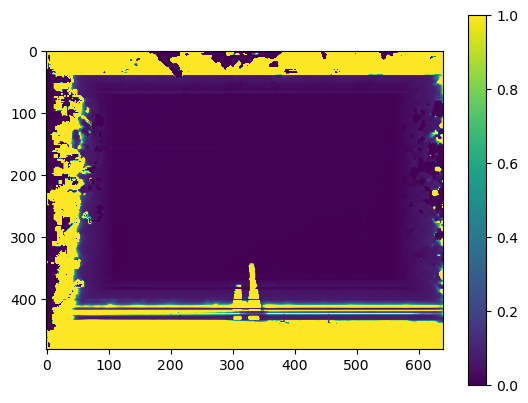

We are processing raw disp for target and vit_b for reference...
Showing vit_b reference colormap ...


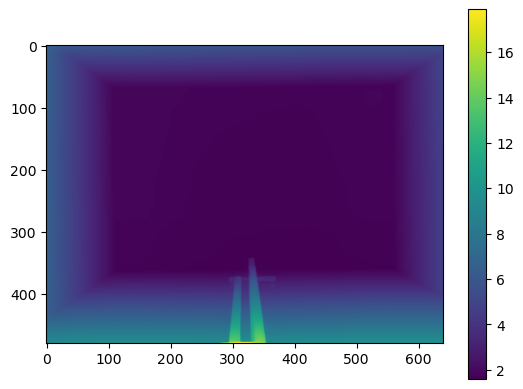

Running on: cuda


100%|██████████| 1500/1500 [00:07<00:00, 210.21it/s]


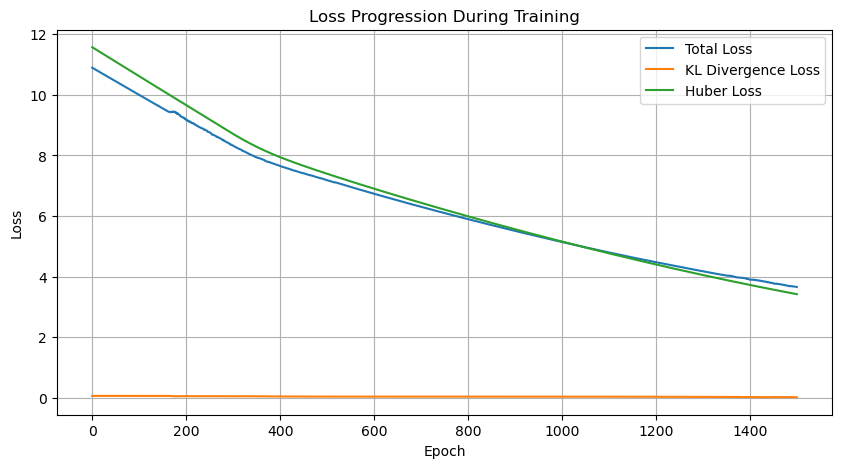

Final refined optimal disp colormap ...


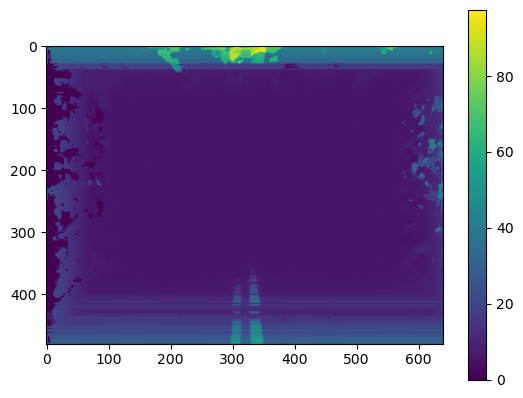

The mean disparity level difference is 3.388378725902876
Showing difference colormap ...


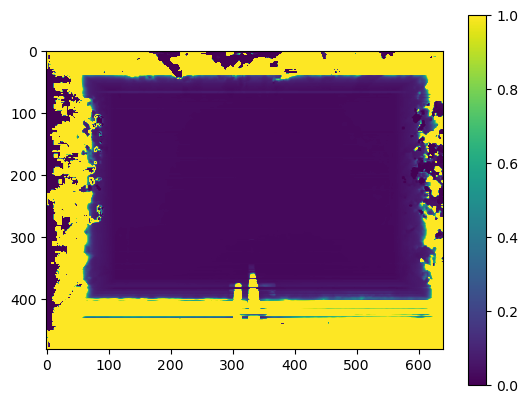

We are processing raw disp for target and vit_l for reference...
Showing vit_l reference colormap ...


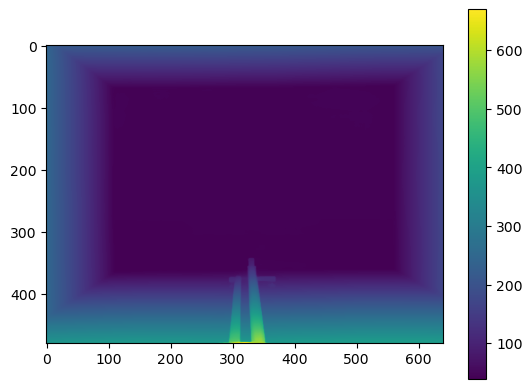

Running on: cuda


100%|██████████| 1500/1500 [00:08<00:00, 167.27it/s]


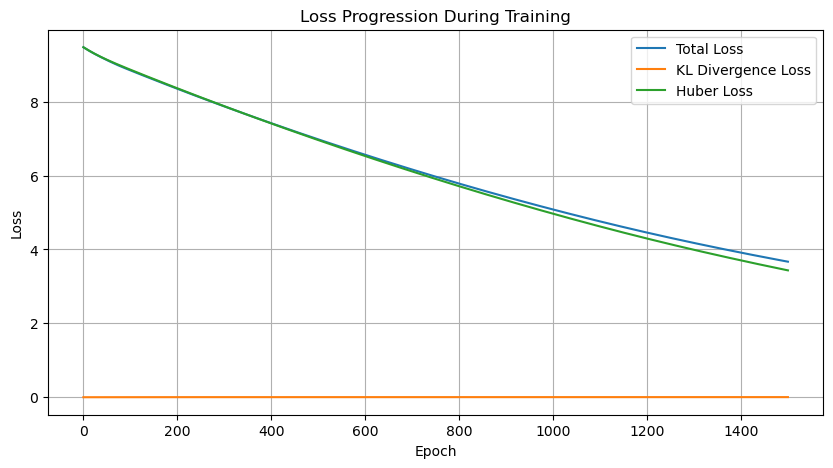

Final refined optimal disp colormap ...


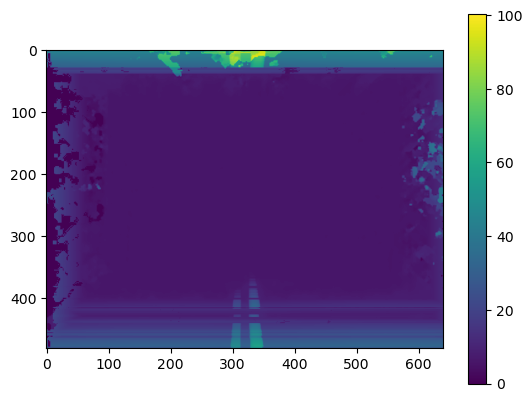

The mean disparity level difference is 3.3929994609373777
Showing difference colormap ...


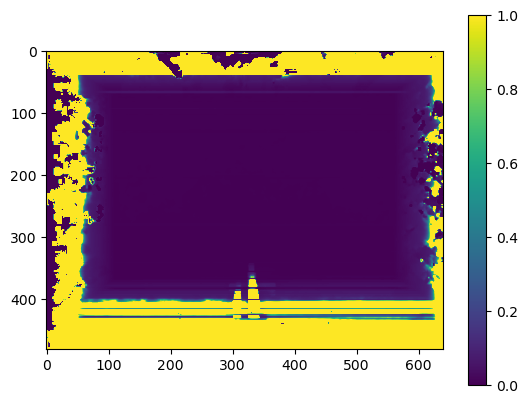

Showing post disp colormap ...


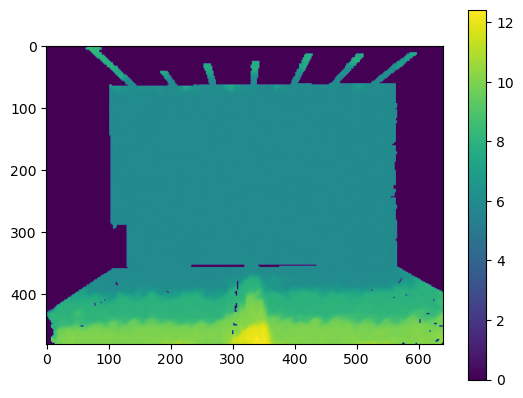

We are processing post disp for target and vit_s for reference...
Showing vit_s reference colormap ...


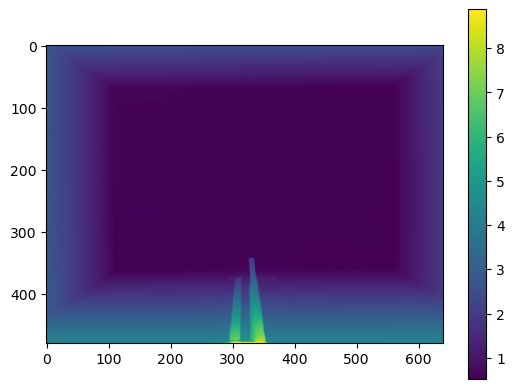

Running on: cuda


100%|██████████| 1500/1500 [00:06<00:00, 222.44it/s]


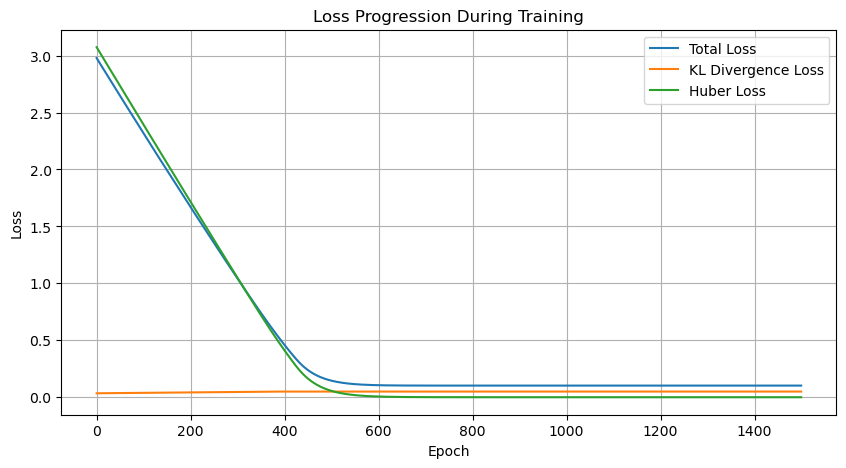

Final refined optimal disp colormap ...


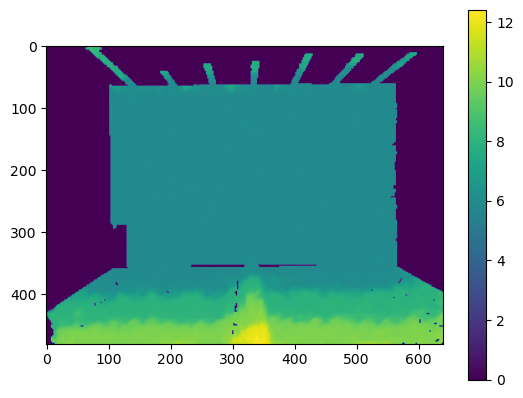

The mean disparity level difference is -0.02190019326439748
Showing difference colormap ...


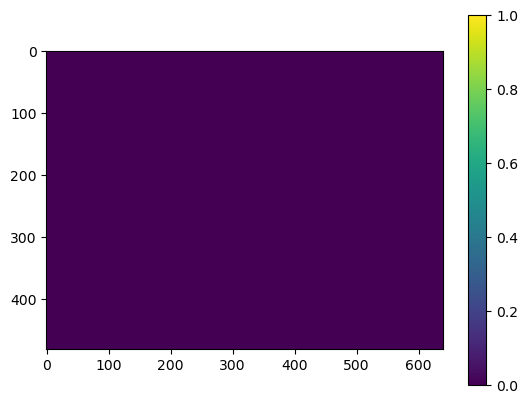

We are processing post disp for target and vit_b for reference...
Showing vit_b reference colormap ...


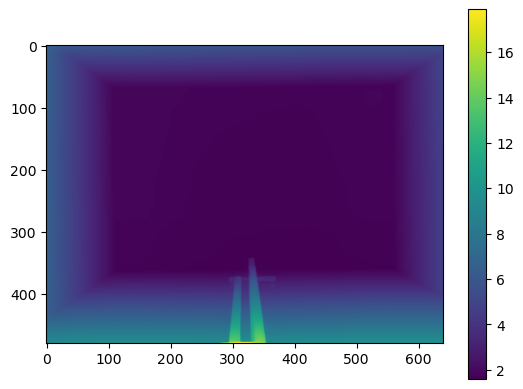

Running on: cuda


100%|██████████| 1500/1500 [00:06<00:00, 221.00it/s]


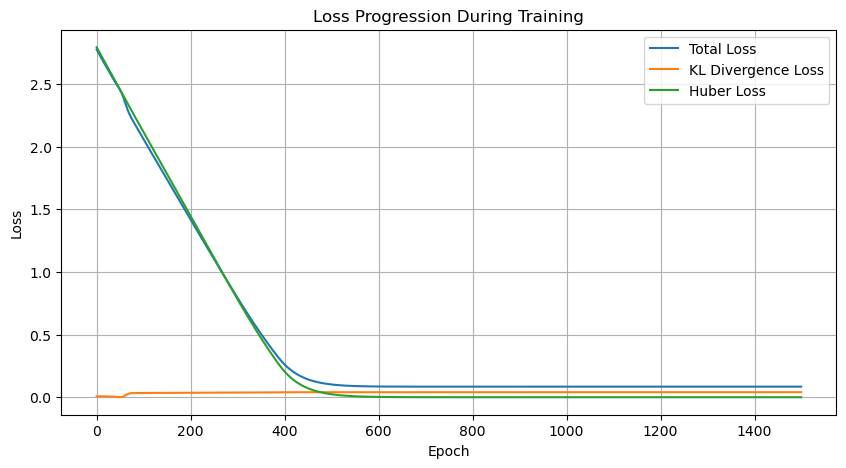

Final refined optimal disp colormap ...


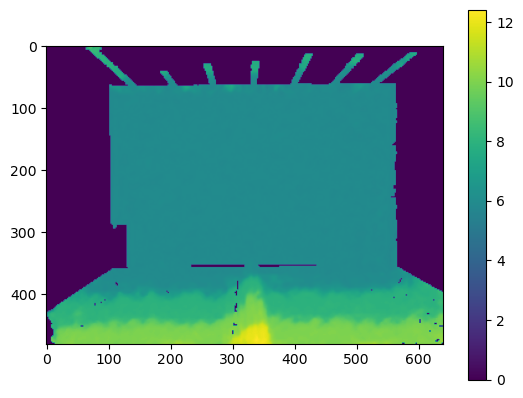

The mean disparity level difference is -0.019929320647691685
Showing difference colormap ...


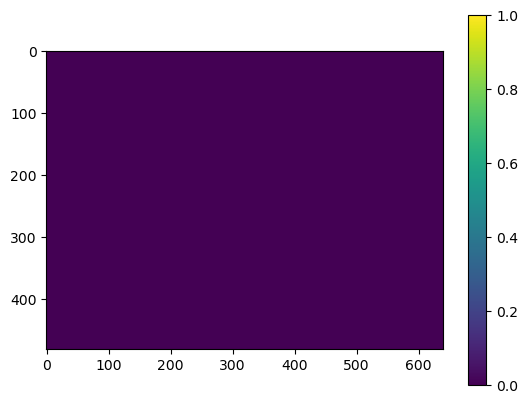

We are processing post disp for target and vit_l for reference...
Showing vit_l reference colormap ...


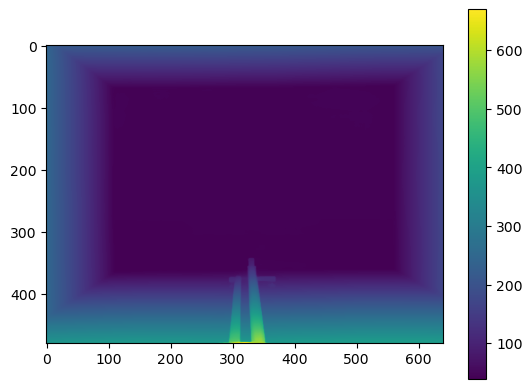

Running on: cuda


100%|██████████| 1500/1500 [00:07<00:00, 189.81it/s]


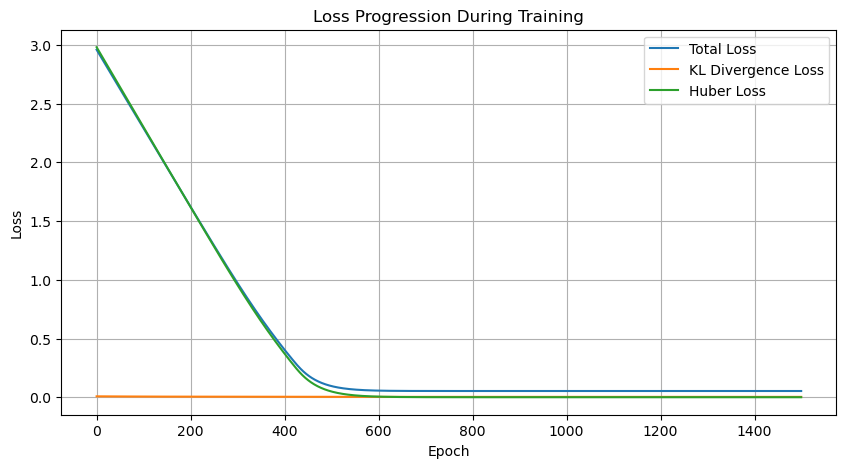

Final refined optimal disp colormap ...


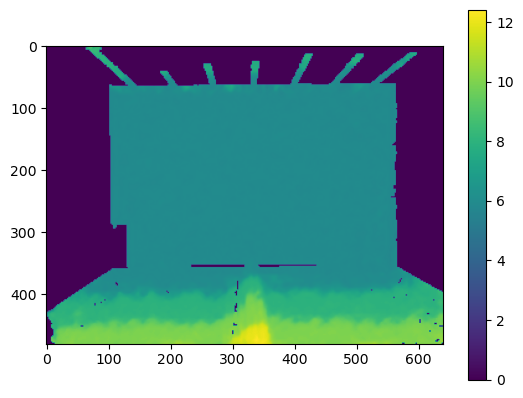

The mean disparity level difference is -0.020360847064293922
Showing difference colormap ...


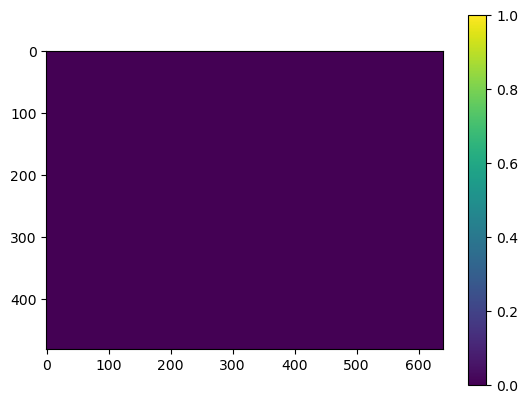

In [17]:
for folder in folders:
    base_dir = os.path.join(top_dir, folder)
    exp_robot = Experiment(base_dir, n_epoches, w_kl, w_hu)
    exp_robot.pipeline()

In [18]:
import gc

gc.collect()

44202